In [1]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Lasso
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
feature_names = diabetes.feature_names

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

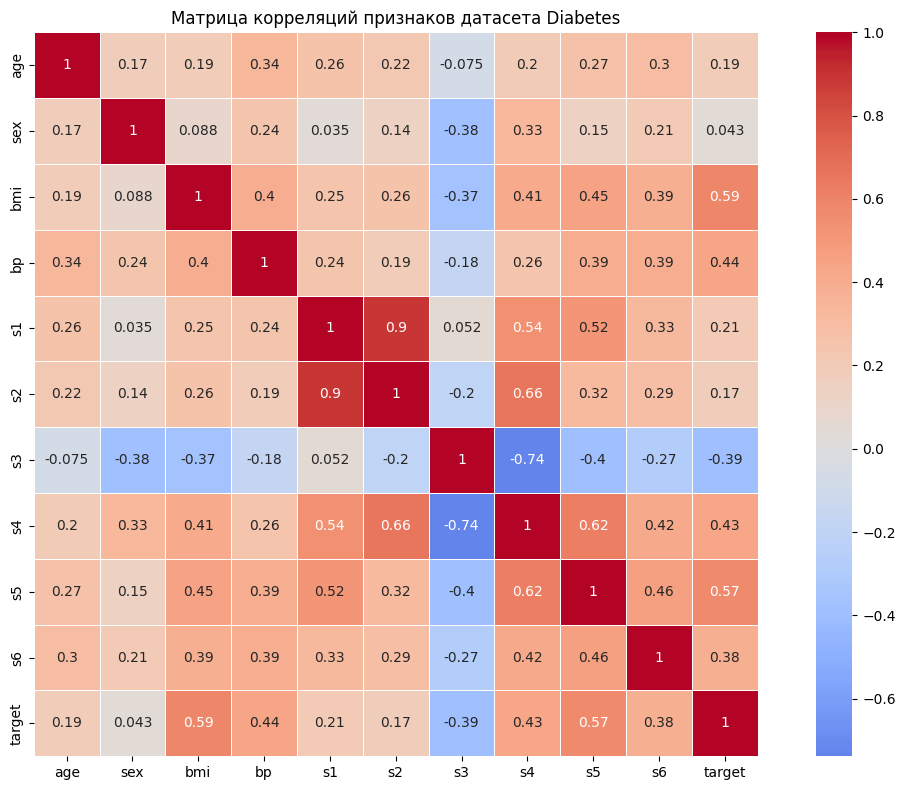

In [2]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Матрица корреляций признаков датасета Diabetes')
plt.tight_layout()
plt.show()

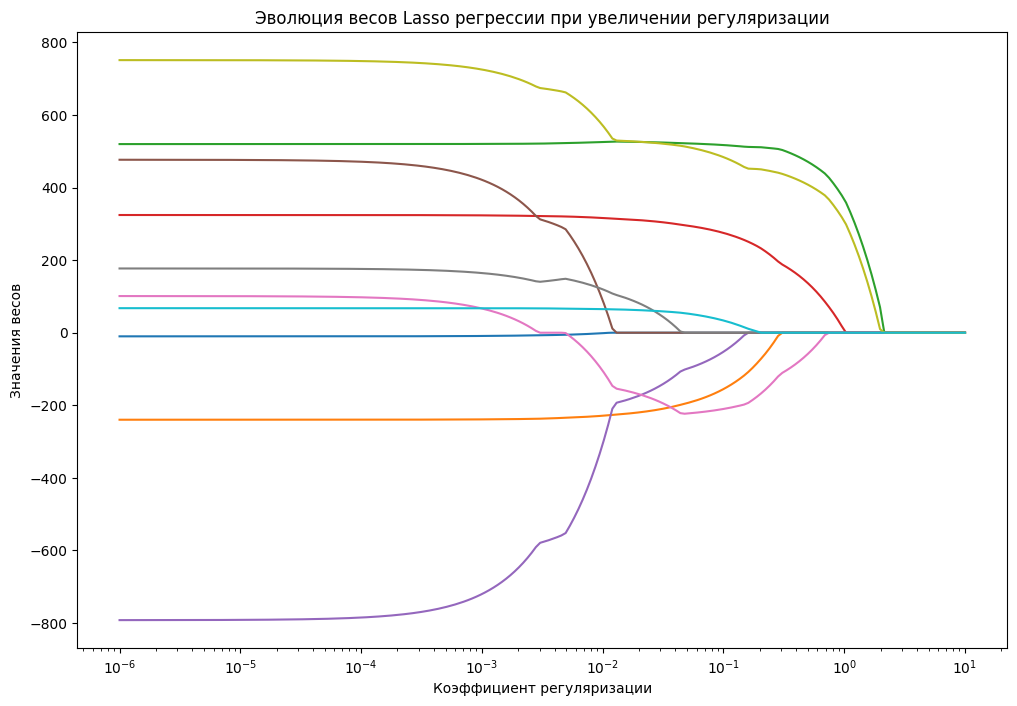

In [3]:
a = 1e-6
alpha_linspace = np.logspace(-6, 1, 200)
coefficients_history = []

for alpha in alpha_linspace:
    lm = Lasso(alpha=alpha, max_iter=10000)
    lm.fit(X, y)
    coefficients_history.append(lm.coef_)

coefficients_history = np.array(coefficients_history)

plt.figure(figsize=(12, 8))

for i in range(coefficients_history.shape[1]):
    plt.semilogx(alpha_linspace, coefficients_history[:, i])

plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Значения весов')
plt.title('Эволюция весов Lasso регрессии при увеличении регуляризации')
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def generate_data(n_samples=100, noise_level=1):

    np.random.seed(42)
    x = np.linspace(0, 5, n_samples)
    func = 3*x + 3*np.sin(3*x) + 3
    noise = np.random.normal(0, noise_level, n_samples)
    y_true = func + noise

    X = np.column_stack([
        np.full(n_samples, 1),
        x,
        np.sin(3*x),
        np.cos(3*x)
    ])

    return X, y_true, x

def make_L1_regression_grad_descent_iteration(X, y, w, mu, alpha):

    grad = 2 * (X @ w - y).T @ X / X.shape[0] + 2 * mu * np.sign(w).T
    w -= alpha * grad.T

    return w


def L1_regression_grad_descent(X, y, mu, alpha, n_iterations=1000, tol=1e-6):

    np.random.seed(42)
    w = np.random.randn(X.shape[1]) * 2
    
    losses = []
    for i in range(n_iterations):
        w_old = w.copy()
        w = make_L1_regression_grad_descent_iteration(X, y, w, mu, alpha)
        
        loss = np.mean((X @ w - y)**2) + mu * np.sum(np.abs(w))
        losses.append(loss)

        if np.linalg.norm(w - w_old) < tol:
            break
    
    return w, losses, i + 1

def cross_validate_L1_regression(X, y, mu_values, alpha_values, n_folds=3, n_iterations=1000):

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    mses = []
    Ws = []
    for mu in mu_values:
        for alpha in alpha_values:

            for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                W = []

                w, losses, n_iters = L1_regression_grad_descent(
                    X_train, y_train, mu, alpha, n_iterations
                )

                W.append(w)
                W = np.array(W)
            
            mean_ws = np.mean(W, axis=0)
            y_pred = X @ mean_ws         
            mse = mean_squared_error(y, y_pred)
            mses.append(mse)
            Ws.append(mean_ws)
    best_weight = Ws[np.argmin(mses)]
    best_mse = mses[np.argmin(mses)]

    return best_weight, best_mse

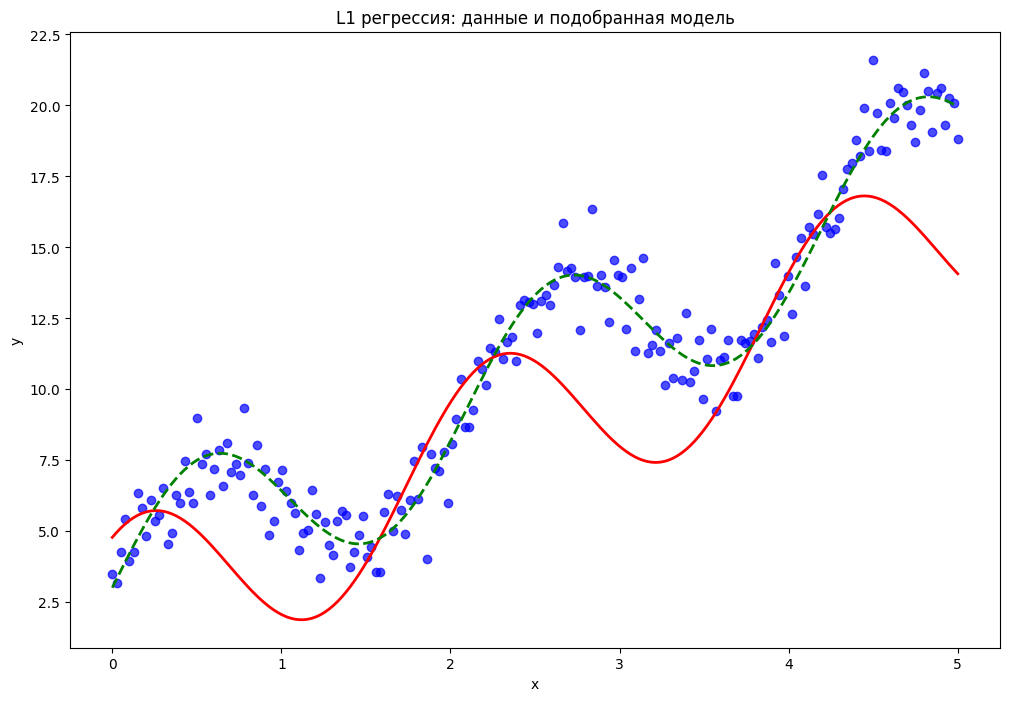

In [74]:
X, y, x = generate_data(200, 1)

mu_values = np.logspace(-10, 1, 15)
alpha_values = np.logspace(-10, -4, 15)


best_w, mse = cross_validate_L1_regression(X, y, mu_values, alpha_values, n_folds=3)

y_pred = X @ best_w

plt.figure(figsize=(12, 8))

plt.scatter(x, y, alpha=0.7, label='Исходные данные с шумом', color='blue')

plt.plot(x, y_pred, color='red', linewidth=2, label='L1 регрессия')

true_func = 3*x + 3*np.sin(3*x) +3
plt.plot(x, true_func, color='green', linestyle='--', linewidth=2, label='Истинная функция')

plt.xlabel('x')
plt.ylabel('y')
plt.title('L1 регрессия: данные и подобранная модель')
plt.show()


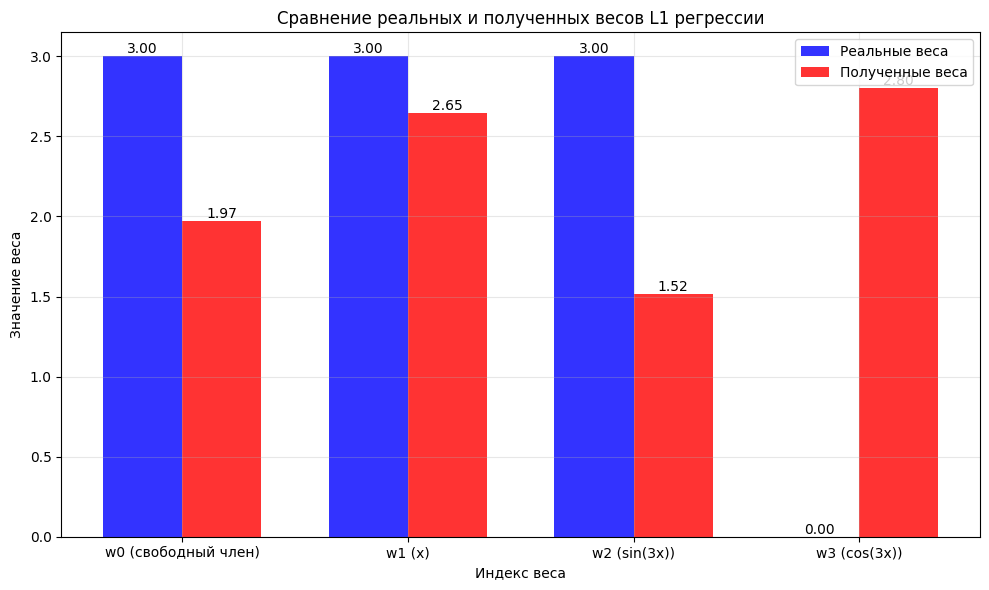

In [75]:
real_w = np.array([3, 3, 3, 0])

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
x_pos = np.arange(len(real_w))

bars1 = ax.bar(x_pos - bar_width/2, real_w, bar_width, 
               label='Реальные веса', alpha=0.8, color='blue')
bars2 = ax.bar(x_pos + bar_width/2, best_w, bar_width, 
               label='Полученные веса', alpha=0.8, color='red')

ax.set_xlabel('Индекс веса')
ax.set_ylabel('Значение веса')
ax.set_title('Сравнение реальных и полученных весов L1 регрессии')
ax.set_xticks(x_pos)
ax.set_xticklabels(['w0 (свободный член)', 'w1 (x)', 'w2 (sin(3x))', 'w3 (cos(3x))'])
ax.legend()
ax.grid(True, alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()